In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install scikit-learn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-data-set/diabetes.csv


# Dataset and Story

**Business Problem**

Can you develop a machine learning model that can predict whether people have diabetes when their characteristics are specified?

The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Persons aged 21 and over living in Phoenix, the 5th largest city in the State of Arizona in the USA. Data used for diabetes research on Pima Indian women. It consists of 768 observations and 8 numerical independent variables. The target variable is specified as "outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

**Variables**
- Pregnancies: Number of pregnancies
- Glucose: Glucose.
- BloodPressure: Blood pressure.
- SkinThickness: Skin Thickness
- Insulin: Insulin.
- BMI: Body mass index.
- DiabetesPedigreeFunction: A function that calculates our probability of having diabetes based on our ancestry.
- Age: Age (years)
- Outcome: Information whether the person has diabetes or not. Have the disease (1) or not (0)


**TASK**

Develop diabetes prediction model by performing literature search, data preprocessing and feature engineering.

# EDA Analysis

In [2]:
df = pd.read_csv("/kaggle/input/diabetes-data-set/diabetes.csv")

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

def grab_col_names(dataframe, cat_th=10, car_th=20): 
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

In [4]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [6]:
# Analysis of Categorical Variables
cat_summary(df, "Outcome")

   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################


count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


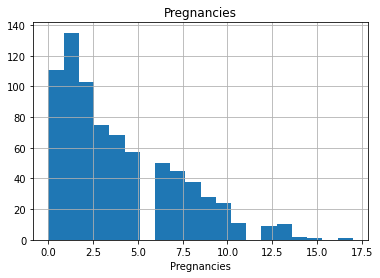

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


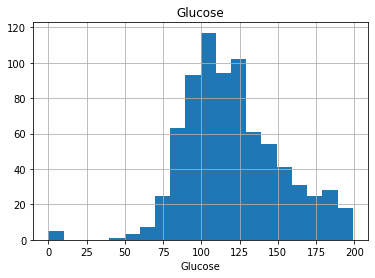

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


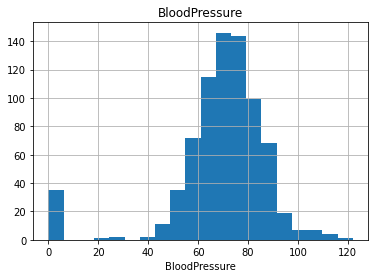

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


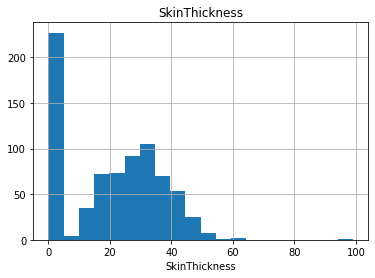

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


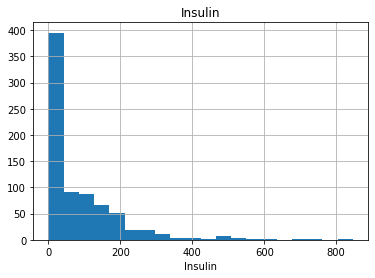

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


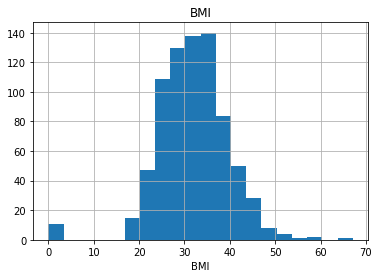

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


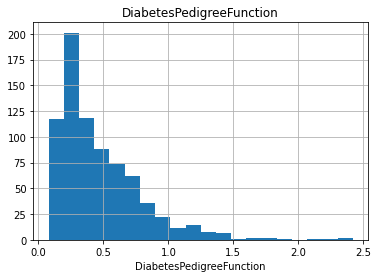

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


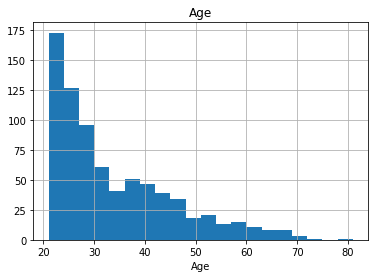

In [7]:
# Analysis of Numerical Variables
for col in num_cols:
     num_summary(df, col, plot=True)

In [8]:
# Analysis of Numerical Variables Based on Target
for col in num_cols:
     target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [9]:
# Examining Correlations
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


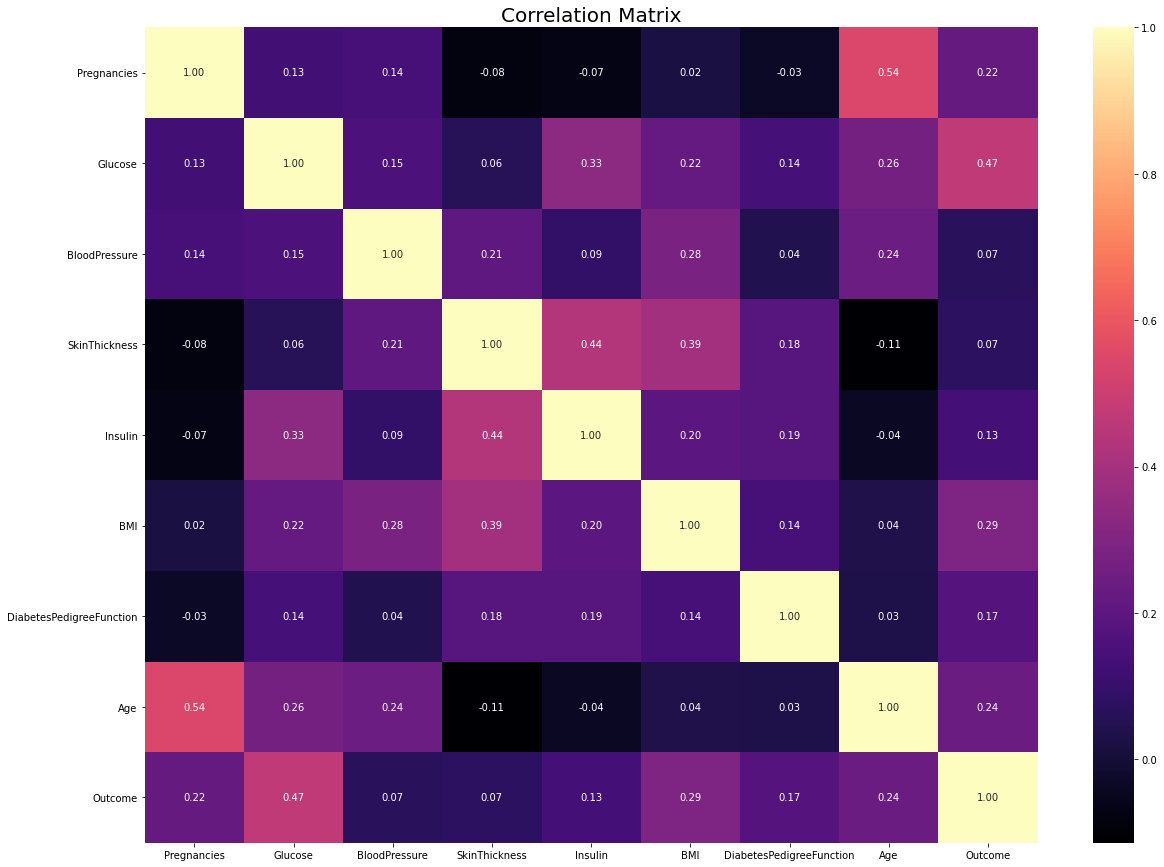

In [10]:
# Correlation Matrix
f, ax = plt.subplots(figsize=[20, 15])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

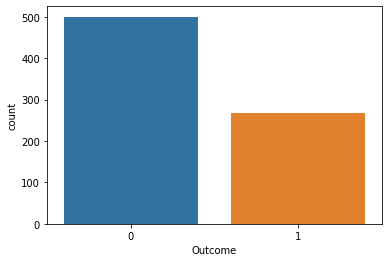

In [11]:
# Distribution of Dependent Variable
sns.countplot('Outcome', data=df)
plt.show()

# Data Preprocessing

In [12]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


def rare_encoder(dataframe, rare_perc, cat_cols):
    rare_columns = [ col for col in cat_cols if (dataframe[col].value_counts() / len(dataframe) < 0.01).sum() > 1]
    for col in rare_columns:
        tmp = dataframe[col].value_counts() / len(dataframe)
        rare_labels = tmp[tmp < rare_perc].index
        dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])
    return dataframe

* It is known that variable values other than Pregnancies and Outcome cannot be 0 in a human.
* Therefore, an action decision should be taken regarding these values. Values that are 0 can be assigned NaN.

In [13]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

# We went to each of the stored variables and recorded the observation values containing 0 as 0
for col in zero_columns:
     df[col] = np.where(df[col] == 0, np.nan, df[col])

In [14]:
# Missing Observation Query
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [15]:
na_columns = missing_values_table(df, na_name=True)

missing_vs_target(df, "Outcome", na_columns)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650
                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [16]:
# Filling the Missing Observations in Categorical Variable Breakdown
def median_target(col):
     temp = df[df[col].notnull()]
     temp = temp[[col, 'Outcome']].groupby(['Outcome'])[[col]].median().reset_index()
     return temp

for col in zero_columns:
     df.loc[(df['Outcome'] == 0) & (df[col].isnull()), col] = median_target(col)[col][0]
     df.loc[(df['Outcome'] == 1) & (df[col].isnull()), col] = median_target(col)[col][1]

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [17]:
# Outlier Analysis and Suppression Process
for col in df.columns:
     print(col, check_outlier(df, col))
     if check_outlier(df, col):
         replace_with_thresholds(df, col)


Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
Outcome False


In [18]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age  Outcome
0        6.000  148.000         72.000         35.000  169.500 33.600                     0.627 50.000        1
1        1.000   85.000         66.000         29.000  102.500 26.600                     0.351 31.000        0
2        8.000  183.000         64.000         32.000  169.500 23.300                     0.672 32.000        1
3        1.000   89.000         66.000         23.000   

# Feature Engineering

In [19]:
# Let's divide the age variable into categories and create a new age variable
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

# BMI below 18.5 is underweight, between 18.5 and 24.9 is normal, 30 and above is obese
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])

# Convert glucose value to categorical variable
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

# Creating a categorical variable by considering age and body mass index together
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"

df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"

df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"

df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

# Creating a categorical variable by considering age and glucose values ​​together
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"

df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"

df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"

df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"


# Derive Categorical Variable with Insulin Value
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"


df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

# Enlarging the columns
df.columns = [col.upper() for col in df.columns]

check_df(df)

##################### Shape #####################
(768, 15)
##################### Types #####################
PREGNANCIES                  float64
GLUCOSE                      float64
BLOODPRESSURE                float64
SKINTHICKNESS                float64
INSULIN                      float64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                          float64
OUTCOME                        int64
NEW_AGE_CAT                   object
NEW_BMI                     category
NEW_GLUCOSE                 category
NEW_AGE_BMI_NOM               object
NEW_AGE_GLUCOSE_NOM           object
NEW_INSULIN_SCORE             object
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN    BMI  DIABETESPEDIGREEFUNCTION    AGE  OUTCOME NEW_AGE_CAT     NEW_BMI  NEW_GLUCOSE NEW_AGE_BMI_NOM  \
0        6.000  148.000         72.000         35.000  169.500 33.600                     0.627 50.000  

# Encoding

In [20]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [21]:
# LABEL ENCODING

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

In [22]:
for col in binary_cols:
    df = label_encoder(df, col)

In [23]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,1,Obese,Prediabetes,obesesenior,highsenior,0
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,0,Overweight,Normal,obesemature,normalmature,1
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,0,Healthy,Prediabetes,obesemature,highmature,0
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,Overweight,Normal,obesemature,normalmature,1
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,0,Obese,Normal,obesemature,highmature,0


In [24]:
# ONE-HOT ENCODING

df = pd.get_dummies(df, drop_first=True)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


# Modelling

In [25]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

lgr = LogisticRegression(solver='liblinear')
lgr_model = lgr.fit(X_train, y_train)

In [26]:
# TRAIN ERROR
y_pred = lgr_model.predict(X_train)

# Accuracy
accuracy_score(y_train, y_pred)


0.8436482084690554

In [27]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       400
           1       0.79      0.76      0.77       214

    accuracy                           0.84       614
   macro avg       0.83      0.82      0.83       614
weighted avg       0.84      0.84      0.84       614



In [28]:
# TEST ERROR
y_pred = lgr_model.predict(X_test)
y_prob = lgr_model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_score(y_test, y_pred)

0.8831168831168831

In [29]:
# Precision
precision_score(y_test, y_pred)

0.8461538461538461

In [30]:
# Recall
recall_score(y_test, y_pred)

0.8148148148148148

In [31]:
# F1
f1_score(y_test, y_pred)

0.830188679245283

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       100
           1       0.85      0.81      0.83        54

    accuracy                           0.88       154
   macro avg       0.87      0.87      0.87       154
weighted avg       0.88      0.88      0.88       154



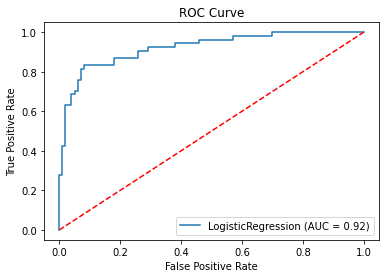

In [33]:
# ROC Curve
plot_roc_curve(lgr_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [34]:
# AUC
roc_auc_score(y_test, y_prob)

0.9218518518518518

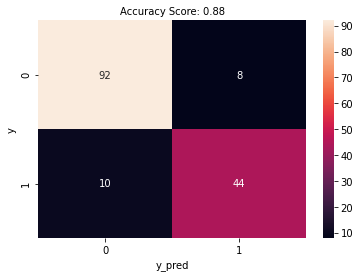

In [35]:
# Confusion Matrix
def plot_confusion_matrix(y, y_pred):
     acc = round(accuracy_score(y, y_pred), 2)
     cm = confusion_matrix(y, y_pred)
     sns.heatmap(cm, annot=True, fmt=".0f")
     plt.xlabel('y_pred')
     plt.ylabel('y')
     plt.title('Accuracy Score: {0}'.format(acc), size=10)
     plt.show()

plot_confusion_matrix(y_test, y_pred)